**OpenViSUS: read from a remote dataset**


In [1]:
import os,sys

# Here are commands to install a package (OpenVisus) directly from a jupyter notebook
# after you install those once you can comment those comment
# !{sys.executable} -m pip install numpy matplotlib OpenVisus

In [2]:
import os,sys
import math
import matplotlib.pyplot as plt
import numpy
import ipywidgets 

def ShowData(data):
    fig = plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()

In [3]:
from OpenVisus import *

Starting OpenVisus c:\python38\lib\site-packages\OpenVisus\__init__.py 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0) ...


In [4]:
db=LoadDataset("http://molniya.sci.utah.edu/mod_visus?dataset=agricolture_time")
print(db.getDatasetBody().toString())

<dataset url="http://molniya.sci.utah.edu/mod_visus?dataset=agricolture_time" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V01010101010101010101010101010101" />
		<box value="0 36765 0 39457" />
		<bitsperblock value="16" />
		<blocksperfile value="256" />
		<block_interleaving value="0" />
		<filename_template value="/usr/sci/cedmav/data/neon/agricolture/agricolture_time/%04x.bin" />
		<missing_blocks value="False" />
		<time_template value="time%03d/" />
		<field name="data" description="" index="" default_compression="" default_layout="0" default_value="0" filter="" dtype="uint8[4]" />
		<timestep from="0" to="6" step="1" />
	</idxfile>
</dataset>


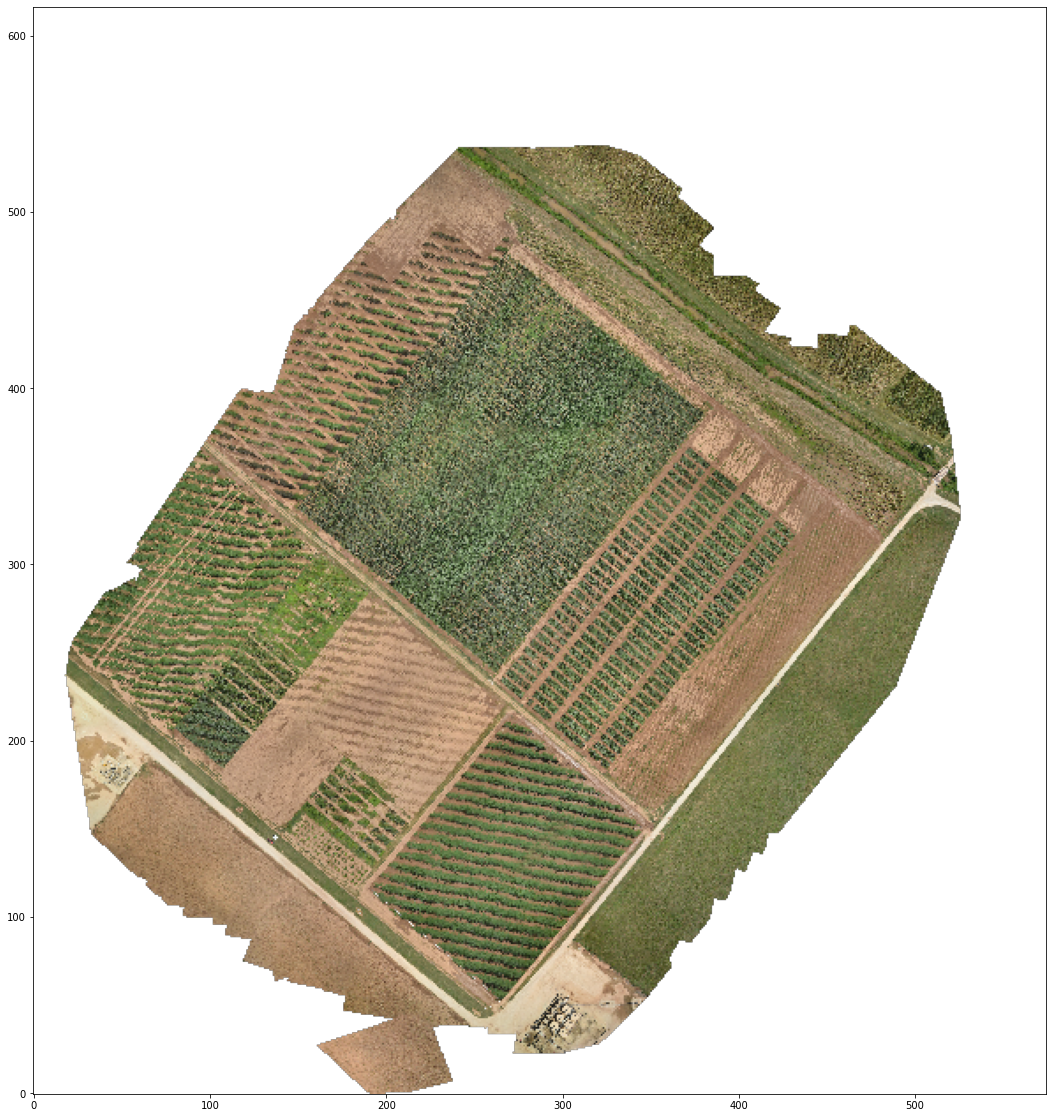

In [5]:
# do not query full resolution but up to 2 ^20 samples in logic space
logic_box=db.getLogicBox(x=[0.0,1.0],y=[0.0,1.0])

def ReadData(time=db.getTime(),max_resolution=20):
    return db.read(logic_box=logic_box,time=time, max_resolution=max_resolution)

# if float range means alpha,beta
data=ReadData()
ShowData(data)

In [6]:
def onTimeChanged(time):
    ShowData(ReadData(time=time))

ipywidgets.interact(
    onTimeChanged, 
    time=ipywidgets.widgets.IntSlider(value=0,min=0,max=4,step=1))

interactive(children=(IntSlider(value=0, description='time', max=4), Output()), _dom_classes=('widget-interact…

<function __main__.onTimeChanged(time)>

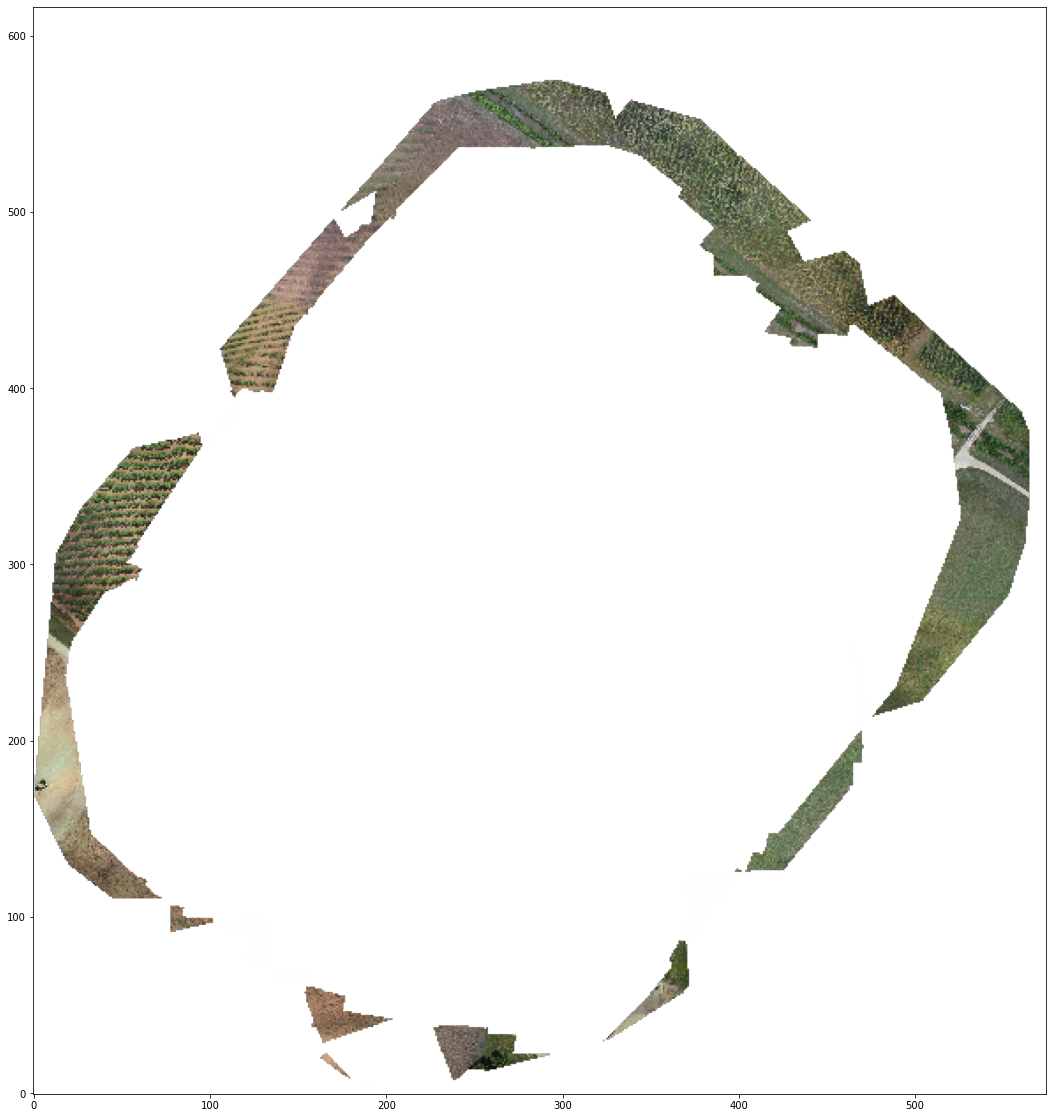

In [7]:
data = ReadData(time=1)-ReadData(time=0)
ShowData(data)

In [8]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray    
    
def onTimesChanged(time0,time1):
    ShowData(
        rgb2gray(ReadData(time=time1))-
        rgb2gray(ReadData(time=time0))
    )
    
ipywidgets.interact(onTimesChanged, 
    time0=ipywidgets.widgets.IntSlider(value=0,min=0, max=6, step=1), 
    time1=ipywidgets.widgets.IntSlider(value=1,min=0, max=6, step=1))

interactive(children=(IntSlider(value=0, description='time0', max=6), IntSlider(value=1, description='time1', …

<function __main__.onTimesChanged(time0, time1)>